In [1]:
import pandas as pd
from datasets import load_dataset

domain_worker_desires = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_desires.csv")["train"].to_pandas()

task_summary = (
    domain_worker_desires
    .groupby("Task")
    .agg({
        "Automation Desire Rating": "mean",
        "Job Security Rating":    "mean",
        "Enjoyment Rating":       "mean",
    })
    .reset_index()
)

task_to_occ = (
    domain_worker_desires[["Task", "Occupation (O*NET-SOC Title)"]]
    .drop_duplicates(subset="Task")
)

task_stats = (
    task_summary
    .merge(task_to_occ, on="Task", how="left")
    .sort_values("Automation Desire Rating", ascending=False)
)

## Basic Info

In [2]:
# Print top-3-automation-desire tasks and bottom-3-automation-desire tasks
print("Top 3 Automation Desire Tasks:")
for i, row in task_stats.head(3).iterrows():
    print(f"Task: {row['Task']}")
    print(f"Automation Desire Rating: {row['Automation Desire Rating']}")
print("\nBottom 3 Automation Desire Tasks:")
for i, row in task_stats.tail(3).iterrows():
    print(f"Task: {row['Task']}")
    print(f"Automation Desire Rating: {row['Automation Desire Rating']}")

Top 3 Automation Desire Tasks:
Task: Schedule appointments with clients.
Automation Desire Rating: 5.0
Task: Maintain files of information relating to emergency calls, such as personnel rosters and emergency call-out and pager files.
Automation Desire Rating: 4.666666666666667
Task: Issue and record adjustments to pay related to previous errors or retroactive increases.
Automation Desire Rating: 4.6

Bottom 3 Automation Desire Tasks:
Task: Write text, such as stories, articles, editorials, or newsletters.
Automation Desire Rating: 1.6
Task: Contact potential vendors to determine material availability.
Automation Desire Rating: 1.5
Task: Trace lost, delayed, or misdirected baggage for customers.
Automation Desire Rating: 1.5


In [3]:
# Print top-20 tasks with highest automation desire
print("Top 20 Automation Desire Tasks:")
for i, row in task_stats.head(20).iterrows():
    print(f"{row['Occupation (O*NET-SOC Title)']}: {row['Task']}")
    print(f"Automation Desire Rating: {row['Automation Desire Rating']}")
    print("-----------------------")

Top 20 Automation Desire Tasks:
Tax Preparers: Schedule appointments with clients.
Automation Desire Rating: 5.0
-----------------------
Public Safety Telecommunicators: Maintain files of information relating to emergency calls, such as personnel rosters and emergency call-out and pager files.
Automation Desire Rating: 4.666666666666667
-----------------------
Payroll and Timekeeping Clerks: Issue and record adjustments to pay related to previous errors or retroactive increases.
Automation Desire Rating: 4.6
-----------------------
Desktop Publishers: Convert various types of files for printing or for the Internet, using computer software.
Automation Desire Rating: 4.5
-----------------------
Online Merchants: Create or maintain database of customer accounts.
Automation Desire Rating: 4.5
-----------------------
Quality Control Systems Managers: Direct the tracking of defects, test results, or other regularly reported quality control data.
Automation Desire Rating: 4.5
----------------

In [4]:
print("Bottom 20 Automation Desire Tasks:")
for i, row in task_stats.tail(20).iloc[::-1].iterrows():
    print(f"{row['Occupation (O*NET-SOC Title)']}: {row['Task']}")
    print(f"Automation Desire Rating: {row['Automation Desire Rating']}")
    print("-----------------------")

Bottom 20 Automation Desire Tasks:
Reservation and Transportation Ticket Agents and Travel Clerks: Trace lost, delayed, or misdirected baggage for customers.
Automation Desire Rating: 1.5
-----------------------
Logistics Analysts: Contact potential vendors to determine material availability.
Automation Desire Rating: 1.5
-----------------------
Editors: Write text, such as stories, articles, editorials, or newsletters.
Automation Desire Rating: 1.6
-----------------------
Reservation and Transportation Ticket Agents and Travel Clerks: Contact customers or travel agents to advise them of travel conveyance changes or to confirm reservations.
Automation Desire Rating: 1.6666666666666667
-----------------------
Video Game Designers: Provide feedback to designers and other colleagues regarding game design features.
Automation Desire Rating: 1.6666666666666667
-----------------------
Librarians and Media Collections Specialists: Code, classify, and catalog books, publications, films, audio-

In [5]:
from scipy.stats import spearmanr

# Automation desire vs. job loss concern
r1_s, p1_s = spearmanr(task_stats['Automation Desire Rating'], task_stats['Job Security Rating'])

# Automation desire vs. work enjoyment
r2_s, p2_s = spearmanr(task_stats['Automation Desire Rating'], task_stats['Enjoyment Rating'])

print(f"Spearman correlation between Automation Desire and Job Security: {r1_s:.3f}, p-value: {p1_s}")
print(f"Spearman correlation between Automation Desire and Enjoyment Rating: {r2_s:.3f}, p-value: {p2_s}")

Spearman correlation between Automation Desire and Job Security: -0.223, p-value: 5.743615023579947e-11
Spearman correlation between Automation Desire and Enjoyment Rating: -0.284, p-value: 3.885933829852834e-17


## Plotting Automation Desire Rank

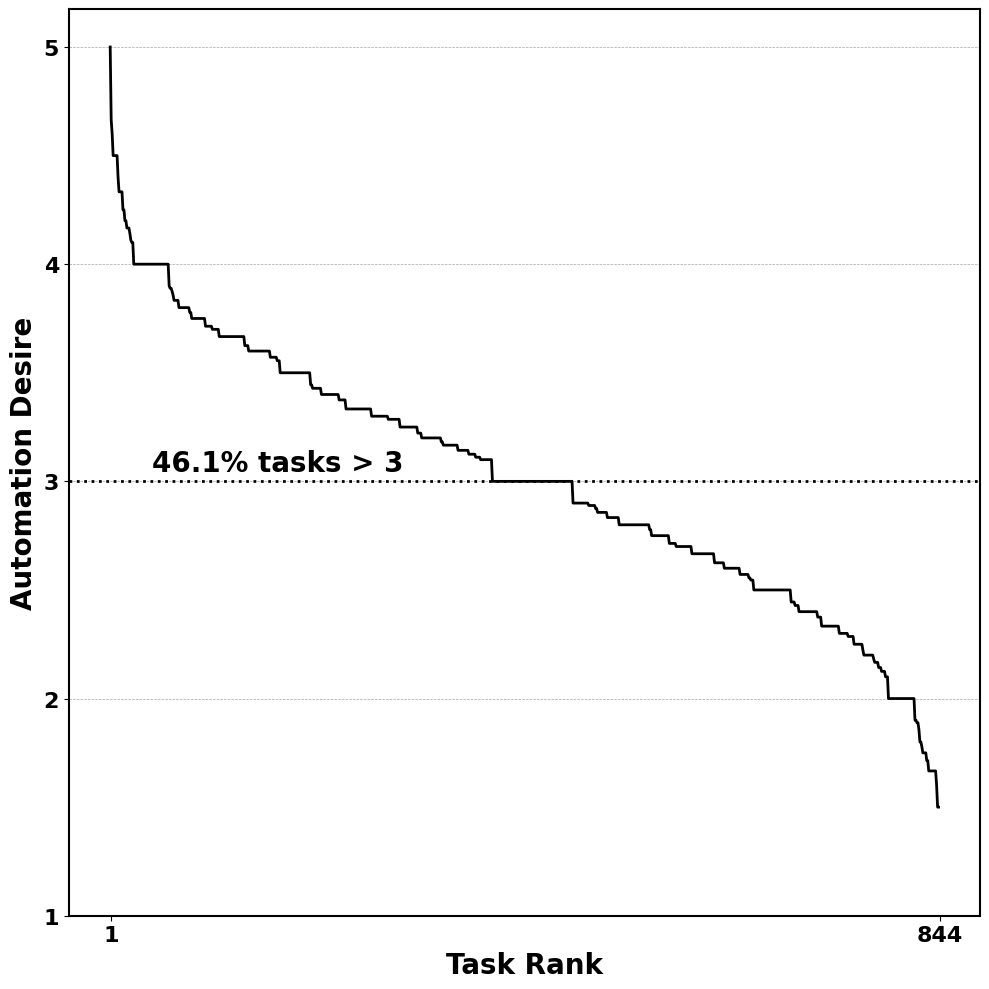

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np

# Rank tasks (0 = highest automation desire)
task_stats["rank"] = range(len(task_stats))

# --- Select percentiles ---
percentiles = np.arange(100, 0, -5)
indices = [int(np.percentile(task_stats.index, 100 - p)) for p in percentiles]
highlighted = task_stats.loc[indices].reset_index(drop=True)

# --- Calculate percentage of tasks with automation desire > 3 ---
percent_high_desire = (task_stats["Automation Desire Rating"] > 3).mean() * 100

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(10, 10))  # 12, 10))
fig.patch.set_facecolor('white')    # white background
ax1.set_facecolor('white')          # also white background for the axes

# Set only horizontal grid
ax1.grid(True, axis='y', color="gray", linestyle='--', linewidth=0.5, alpha=0.7)
ax1.grid(False, axis='x')

# Fill area under automation desire curve
# ax1.fill_between(
#     task_stats["rank"],
#     1,  # Start from 1 instead of 0
#     task_stats["Automation Desire Rating"],
#     color="lightgray",
#     alpha=0.4
# )

# Automation desire curve
ax1.plot(task_stats["rank"], task_stats["Automation Desire Rating"], color='black', linewidth=2, label="Automation Desire")

# Horizontal dotted line at y = 3
ax1.axhline(y=3, color='black', linestyle=':', linewidth=2)

# Add percentage annotation
ax1.text(
    task_stats["rank"].max() * 0.05,
    3.05,
    f"{percent_high_desire:.1f}% tasks > 3",
    fontsize=20,
    fontweight='bold',
    color='black',
    ha='left'
)

# Connecting lines and dots for highlighted tasks
# for i, row in highlighted.iterrows():
#     ax1.scatter(row["rank"], row["Job Security Rating"], color='#bd4e33', alpha=1, label='Job Loss Concern' if i == 0 else "", marker='o')
#     ax1.scatter(row["rank"], row["Enjoyment Rating"], color='#f32672', alpha=1, label='Enjoyment' if i == 0 else "", marker='^')
#     ax1.plot(
#         [row["rank"]]*2,
#         [row["Job Security Rating"], row["Enjoyment Rating"]],
#         color='gray',
#         alpha=1,
#         linewidth=1.5
#     )

# Axis settings
ax1.set_yticks([1, 2, 3, 4, 5])
ax1.set_yticklabels([1, 2, 3, 4, 5], fontdict={"fontsize": 16, "fontweight": "bold", "color": "black"})
ax1.set_ylabel("Automation Desire", fontdict={"fontsize": 20, "fontweight": "bold", "color": "black"})
ax1.set_xlabel("Task Rank", fontdict={"fontsize": 20, "fontweight": "bold", "color": "black"})
ax1.set_xticks([1, len(task_stats)])
ax1.set_xticklabels([1, len(task_stats)], fontdict={"fontsize": 16, "fontweight": "bold", "color": "black"})  # Show only first, middle, and last ticks

# Top task labels
# ax2 = ax1.twiny()
# ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks(highlighted["rank"])
# ax2.set_xticklabels(highlighted["Task"], rotation=45, ha='left')

# Grid and border styling
# ax2.grid(True, axis='y', color="gray", linestyle='--', linewidth=0.5, alpha=0.7)
# ax2.grid(False, axis='x')

for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
# for spine in ax2.spines.values():
#     spine.set_edgecolor('black')
#     spine.set_linewidth(1.5)

# Legend & layout
# legend = ax1.legend(
#     loc="upper right",
#     bbox_to_anchor=(0.95, 0.95),
#     prop=fm.FontProperties(weight='bold', size=16),
#     frameon=True
# )
# legend.get_frame().set_facecolor('white')
# legend.get_frame().set_edgecolor('gray')
# legend.get_frame().set_linewidth(1.5)
# legend.get_frame().set_boxstyle('round,pad=0.5')
# for text in legend.get_texts():
#     text.set_fontweight('bold')

plt.tight_layout()
plt.show()



In [7]:
import os


def plot_sector_task_profile(sector, file_path=None, show_legend=True):
    """
    Plot automation desire and associated metrics for a given sector.
    
    Args:
        sector (str): Name of the sector (used to load occupations).
        file_path (str, optional): If provided, save the figure to this path.
        show_legend (bool, optional): Whether to show the legend.
    """
    # Load sector occupation list
    sector_filename = f"../external_data/onet_data/onet_sector/{sector.replace(' ', '_')}.csv"
    if not os.path.exists(sector_filename):
        raise FileNotFoundError(f"Sector file not found: {sector_filename}")
    
    sector_occupations = pd.read_csv(sector_filename)["Occupation"].unique()
    
    # Filter responses
    responses_sector = domain_worker_desires[domain_worker_desires["Occupation (O*NET-SOC Title)"].isin(sector_occupations)]
    
    if responses_sector.empty:
        raise ValueError(f"No matching responses found for sector: {sector}")
    
    # Aggregate metrics
    task_stats = responses_sector.groupby("Task").agg({
        "Automation Desire Rating": "mean",
        "Job Security Rating": "mean",
        "Enjoyment Rating": "mean"
    }).sort_values("Automation Desire Rating", ascending=False).reset_index()
    
    task_stats["rank"] = range(len(task_stats))
    
    # Select percentiles
    percentiles = np.arange(100, 0, -5)
    indices = [int(np.percentile(task_stats.index, 100 - p)) for p in percentiles]
    highlighted = task_stats.loc[indices].reset_index(drop=True)
    
    # Calculate percentage of workflows with automation desire > 3
    percent_high_desire = (task_stats["Automation Desire Rating"] > 3).mean() * 100
    
    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(10, 10))
    fig.patch.set_facecolor('white')    # white background
    ax1.set_facecolor('white')          # also white background for the axes
    
    # Set only horizontal grid
    ax1.grid(True, axis='y', color="gray", linestyle='--', linewidth=0.5, alpha=0.7)
    ax1.grid(False, axis='x')
    
    # Automation desire curve
    ax1.plot(task_stats["rank"], task_stats["Automation Desire Rating"], color='black', linewidth=2, label="Automation Desire")
    
    # Horizontal dotted line at y = 3
    ax1.axhline(y=3, color='black', linestyle=':', linewidth=2)
    
    # Add percentage annotation
    ax1.text(
        task_stats["rank"].max() * 0.05,
        3.05,
        f"{percent_high_desire:.1f}% tasks > 3",
        fontsize=28,
        fontweight='bold',
        color='black',
        ha='left'
    )
    
    # Connecting lines and dots for highlighted tasks
    # for i, row in highlighted.iterrows():
    #     ax1.scatter(row["rank"], row["Job Security Rating"], color='#bd4e33', alpha=1, label='Job Loss Concern' if i == 0 else "", marker='o')
    #     ax1.scatter(row["rank"], row["Enjoyment Rating"], color='#f32672', alpha=1, label='Enjoyment' if i == 0 else "", marker='^')
    #     ax1.plot(
    #         [row["rank"]]*2,
    #         [row["Job Security Rating"], row["Enjoyment Rating"]],
    #         color='gray',
    #         alpha=1,
    #         linewidth=1.5
    #     )
    
    # Axis settings
    ax1.set_yticks([1, 2, 3, 4, 5])
    ax1.set_yticklabels([1, 2, 3, 4, 5], fontdict={"fontsize": 24, "fontweight": "bold", "color": "black"})
    ax1.set_ylabel("Automation Desire", fontdict={"fontsize": 28, "fontweight": "bold", "color": "black"})
    ax1.set_xlabel("Task Rank", fontdict={"fontsize": 28, "fontweight": "bold", "color": "black"})
    ax1.set_xticks([1, len(task_stats)])
    ax1.set_xticklabels([1, len(task_stats)], fontdict={"fontsize": 24, "fontweight": "bold", "color": "black"})  # Show only first, middle, and last ticks
    
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    if show_legend:
        # Legend & layout
        legend = ax1.legend(
            loc="upper right",
            bbox_to_anchor=(0.95, 0.95),
            prop=fm.FontProperties(weight='bold', size=16),
            frameon=True
        )
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('gray')
        legend.get_frame().set_linewidth(1.5)
        legend.get_frame().set_boxstyle('round,pad=0.5')
        for text in legend.get_texts():
            text.set_fontweight('bold')

    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
    
    print(f"Sector: {sector}, {percent_high_desire:.1f}% workflows > 3")


In [8]:
for sector in [
    "Computer and Mathematical",
    "Office and Administrative Support",
    "Management",
    "Sales and Related",
    "Business and Financial Operations",
    "Educational Instruction and Library",
    "Arts Design Entertainment Sports and Media",
]:
    plot_sector_task_profile(
        sector=sector,
        file_path=f"../local/automation_desire/{sector.replace(' ', '_')}.png",
        show_legend=False
    )

Sector: Computer and Mathematical, 53.8% workflows > 3
Sector: Office and Administrative Support, 42.8% workflows > 3
Sector: Management, 51.1% workflows > 3
Sector: Sales and Related, 44.1% workflows > 3
Sector: Business and Financial Operations, 48.8% workflows > 3
Sector: Educational Instruction and Library, 56.2% workflows > 3
Sector: Arts Design Entertainment Sports and Media, 17.1% workflows > 3


## Plotting Automation Desire Reason

In [9]:
prone_automation_subset = domain_worker_desires[domain_worker_desires["Automation Desire Rating"] >= 3]

reasons = [
    "Reasons for Automation Desire - Free Time",
    "Reasons for Automation Desire - Repetitive",
    "Reasons for Automation Desire - Human Error",
    "Reasons for Automation Desire - Stress",
    "Reasons for Automation Desire - Difficulty"
]
desire_group = [3, 4, 5]

# Create a new DataFrame to hold the counts
reason_counts = {
    "Reason": [],
    "Count": [],
    "Desire Group": []
}
for reason in reasons:
    for group in desire_group:
        count = prone_automation_subset[prone_automation_subset["Automation Desire Rating"] == group][reason].sum()
        reason_counts["Reason"].append(reason)
        reason_counts["Count"].append(count)
        reason_counts["Desire Group"].append(group)

reason_counts = pd.DataFrame(reason_counts)

# Print the result ranked based on the total count for a reason.
print(f"Number of responses: {len(prone_automation_subset)}\n")
reason_counts["Total Count"] = reason_counts.groupby("Reason")["Count"].transform("sum")
reason_counts = reason_counts.sort_values(by=["Total Count"], ascending=False).reset_index(drop=True)
for i, row in reason_counts.iterrows():
    print(f"Reason: {row['Reason']}, Desire Group: {row['Desire Group']}, Count: {row['Count']}")

Number of responses: 3618

Reason: Reasons for Automation Desire - Free Time, Desire Group: 3, Count: 969
Reason: Reasons for Automation Desire - Free Time, Desire Group: 4, Count: 874
Reason: Reasons for Automation Desire - Free Time, Desire Group: 5, Count: 667
Reason: Reasons for Automation Desire - Repetitive, Desire Group: 3, Count: 605
Reason: Reasons for Automation Desire - Repetitive, Desire Group: 4, Count: 573
Reason: Reasons for Automation Desire - Repetitive, Desire Group: 5, Count: 508
Reason: Reasons for Automation Desire - Human Error, Desire Group: 3, Count: 646
Reason: Reasons for Automation Desire - Human Error, Desire Group: 4, Count: 598
Reason: Reasons for Automation Desire - Human Error, Desire Group: 5, Count: 442
Reason: Reasons for Automation Desire - Stress, Desire Group: 3, Count: 333
Reason: Reasons for Automation Desire - Stress, Desire Group: 4, Count: 332
Reason: Reasons for Automation Desire - Stress, Desire Group: 5, Count: 258
Reason: Reasons for Autom

## Percentage of Claude.ai usage of top 10 occupations with the highest automation desire

In [10]:
# Aggregate task-level stats with occupation information
task_stats_with_occupation = domain_worker_desires.groupby("Task").agg({
    "Automation Desire Rating": "mean",
    "Job Security Rating": "mean",
    "Enjoyment Rating": "mean",
    "Occupation (O*NET-SOC Title)": "first"
}).reset_index()

# lowercase task column for merging with Claude usage data
task_stats_with_occupation["Task"] = task_stats_with_occupation["Task"].str.lower()

# Load Claude usage data and rename column for merging
task_claude_usage_data = pd.read_csv('../external_data/usage_from_anthropic.csv')
task_claude_usage_data = task_claude_usage_data.rename({"task_name": "Task"}, axis=1)

# Merge task stats with Claude usage
merged_data = task_stats_with_occupation.merge(task_claude_usage_data, on="Task", how="left")

# Group by occupation and compute mean automation desire and total Claude usage
occupation_stats = merged_data.groupby("Occupation (O*NET-SOC Title)").agg({
    "Automation Desire Rating": "mean",
    "pct": "sum"  
}).reset_index()

# Sort to get top 10 occupations by automation desire
top_10_occupations = occupation_stats.sort_values("Automation Desire Rating", ascending=False).head(10)

# Compute total Claude usage across these top 10
total_claude_usage_top_10 = top_10_occupations["pct"].sum()
# print percentage of usage
print("Percentage of Claude usage amongst top 10 occupations with highest desire: ", total_claude_usage_top_10)
# print occupational breakdown
print("Breakdown by occupation for top 10")
print(top_10_occupations[["Occupation (O*NET-SOC Title)", "pct"]])
print("Sum of usage: ", top_10_occupations["pct"].sum())



Percentage of Claude usage amongst top 10 occupations with highest desire:  1.2591366887727833
Breakdown by occupation for top 10
                     Occupation (O*NET-SOC Title)       pct
76                Public Safety Telecommunicators  0.038045
23   Computer and Information Research Scientists  0.085992
17                            Compliance Officers  0.016547
30                              Data Entry Keyers  0.004169
93                                  Tax Preparers  0.017980
63    Network and Computer Systems Administrators  0.100715
68                            Petroleum Engineers  0.000000
7                    Biofuels Production Managers  0.000000
15                         Clinical Data Managers  0.048208
101                            Web Administrators  0.947480
Sum of usage:  1.2591366887727833
